# Практическая работа №2

## Импорт необходимых библиотек

In [1]:
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from csv import DictWriter

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, RFE, SelectKBest, \
    chi2, SelectFromModel
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, \
    QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from matplotlib.ticker import MultipleLocator
from imblearn.over_sampling import RandomOverSampler, ADASYN, KMeansSMOTE, \
    SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTEN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, InstanceHardnessThreshold,\
    NearMiss, TomekLinks, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, OneSidedSelection, CondensedNearestNeighbour, NeighbourhoodCleaningRule
from functions import plot_roc_curves, plot_bar_graph
from typing import Dict

In [2]:
dataframe_train = pd.read_csv("../data/train.csv")
dataframe_test = pd.read_csv("../data/test.csv")
dataframe_train.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,213892,Male,48,1,35.0,1,1-2 Year,No,24922.0,26.0,86,0
1,269011,Male,58,1,28.0,0,1-2 Year,Yes,63541.0,26.0,57,0
2,31464,Male,44,1,28.0,1,1-2 Year,No,30027.0,26.0,286,0
3,86379,Female,22,1,8.0,0,< 1 Year,Yes,35039.0,152.0,180,0
4,456843,Male,24,1,6.0,1,< 1 Year,No,24149.0,152.0,17,0
5,195890,Female,49,1,28.0,0,1-2 Year,Yes,2630.0,157.0,156,0
6,111681,Male,28,1,6.0,1,< 1 Year,No,31154.0,152.0,150,0
7,427068,Male,22,1,12.0,1,< 1 Year,No,27956.0,152.0,174,0
8,337519,Female,25,1,14.0,1,< 1 Year,No,32658.0,152.0,32,0
9,12666,Male,47,1,0.0,0,1-2 Year,Yes,2630.0,26.0,79,0


Выведем информацию о таблицах.

In [3]:
dataframe_train.info()
dataframe_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    229292 non-null  int64  
 1   Gender                229292 non-null  object 
 2   Age                   229292 non-null  int64  
 3   Driving_License       229292 non-null  int64  
 4   Region_Code           229292 non-null  float64
 5   Previously_Insured    229292 non-null  int64  
 6   Vehicle_Age           229292 non-null  object 
 7   Vehicle_Damage        229292 non-null  object 
 8   Annual_Premium        229292 non-null  float64
 9   Policy_Sales_Channel  229292 non-null  float64
 10  Vintage               229292 non-null  int64  
 11  Response              229292 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 21.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152862 entries, 0 to 152861
Data columns (total 

In [4]:
dataframe_train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Из вывода видно, что в столбцах нет пустых значений. Разделим наши признаки на категориальные и числовые.

In [5]:
dataframe_categorical = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
dataframe_numerical = ["Age", "Driving_License", "Previously_Insured",
                       "Region_Code", "Annual_Premium", "Policy_Sales_Channel",
                       "Vintage"]
dataframe_all = dataframe_numerical + dataframe_categorical
result_column = "Response"

Для всей работы выберем 20000 элементов из датафрейма, используя метод сэмплирования из библиотеки Pandas.

In [6]:
number_of_elements = 20000  # Количество элементов
dataframe_result = dataframe_train.sample(n=number_of_elements, replace=False, random_state=42)
dataframe_train = dataframe_train.sample(n=number_of_elements,
                                         replace=False)  # replace: флаг, указывающий, следует ли использовать повторения при выборке.

# вытащить еще 20000 строчек, нигде не использовать, и после прогнать на лучшей модели, выбрать лучшие признаки только и сделать предобработку, не семплировать, не обучать
dataframe_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 100668 to 97582
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    20000 non-null  int64  
 1   Gender                20000 non-null  object 
 2   Age                   20000 non-null  int64  
 3   Driving_License       20000 non-null  int64  
 4   Region_Code           20000 non-null  float64
 5   Previously_Insured    20000 non-null  int64  
 6   Vehicle_Age           20000 non-null  object 
 7   Vehicle_Damage        20000 non-null  object 
 8   Annual_Premium        20000 non-null  float64
 9   Policy_Sales_Channel  20000 non-null  float64
 10  Vintage               20000 non-null  int64  
 11  Response              20000 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 2.0+ MB


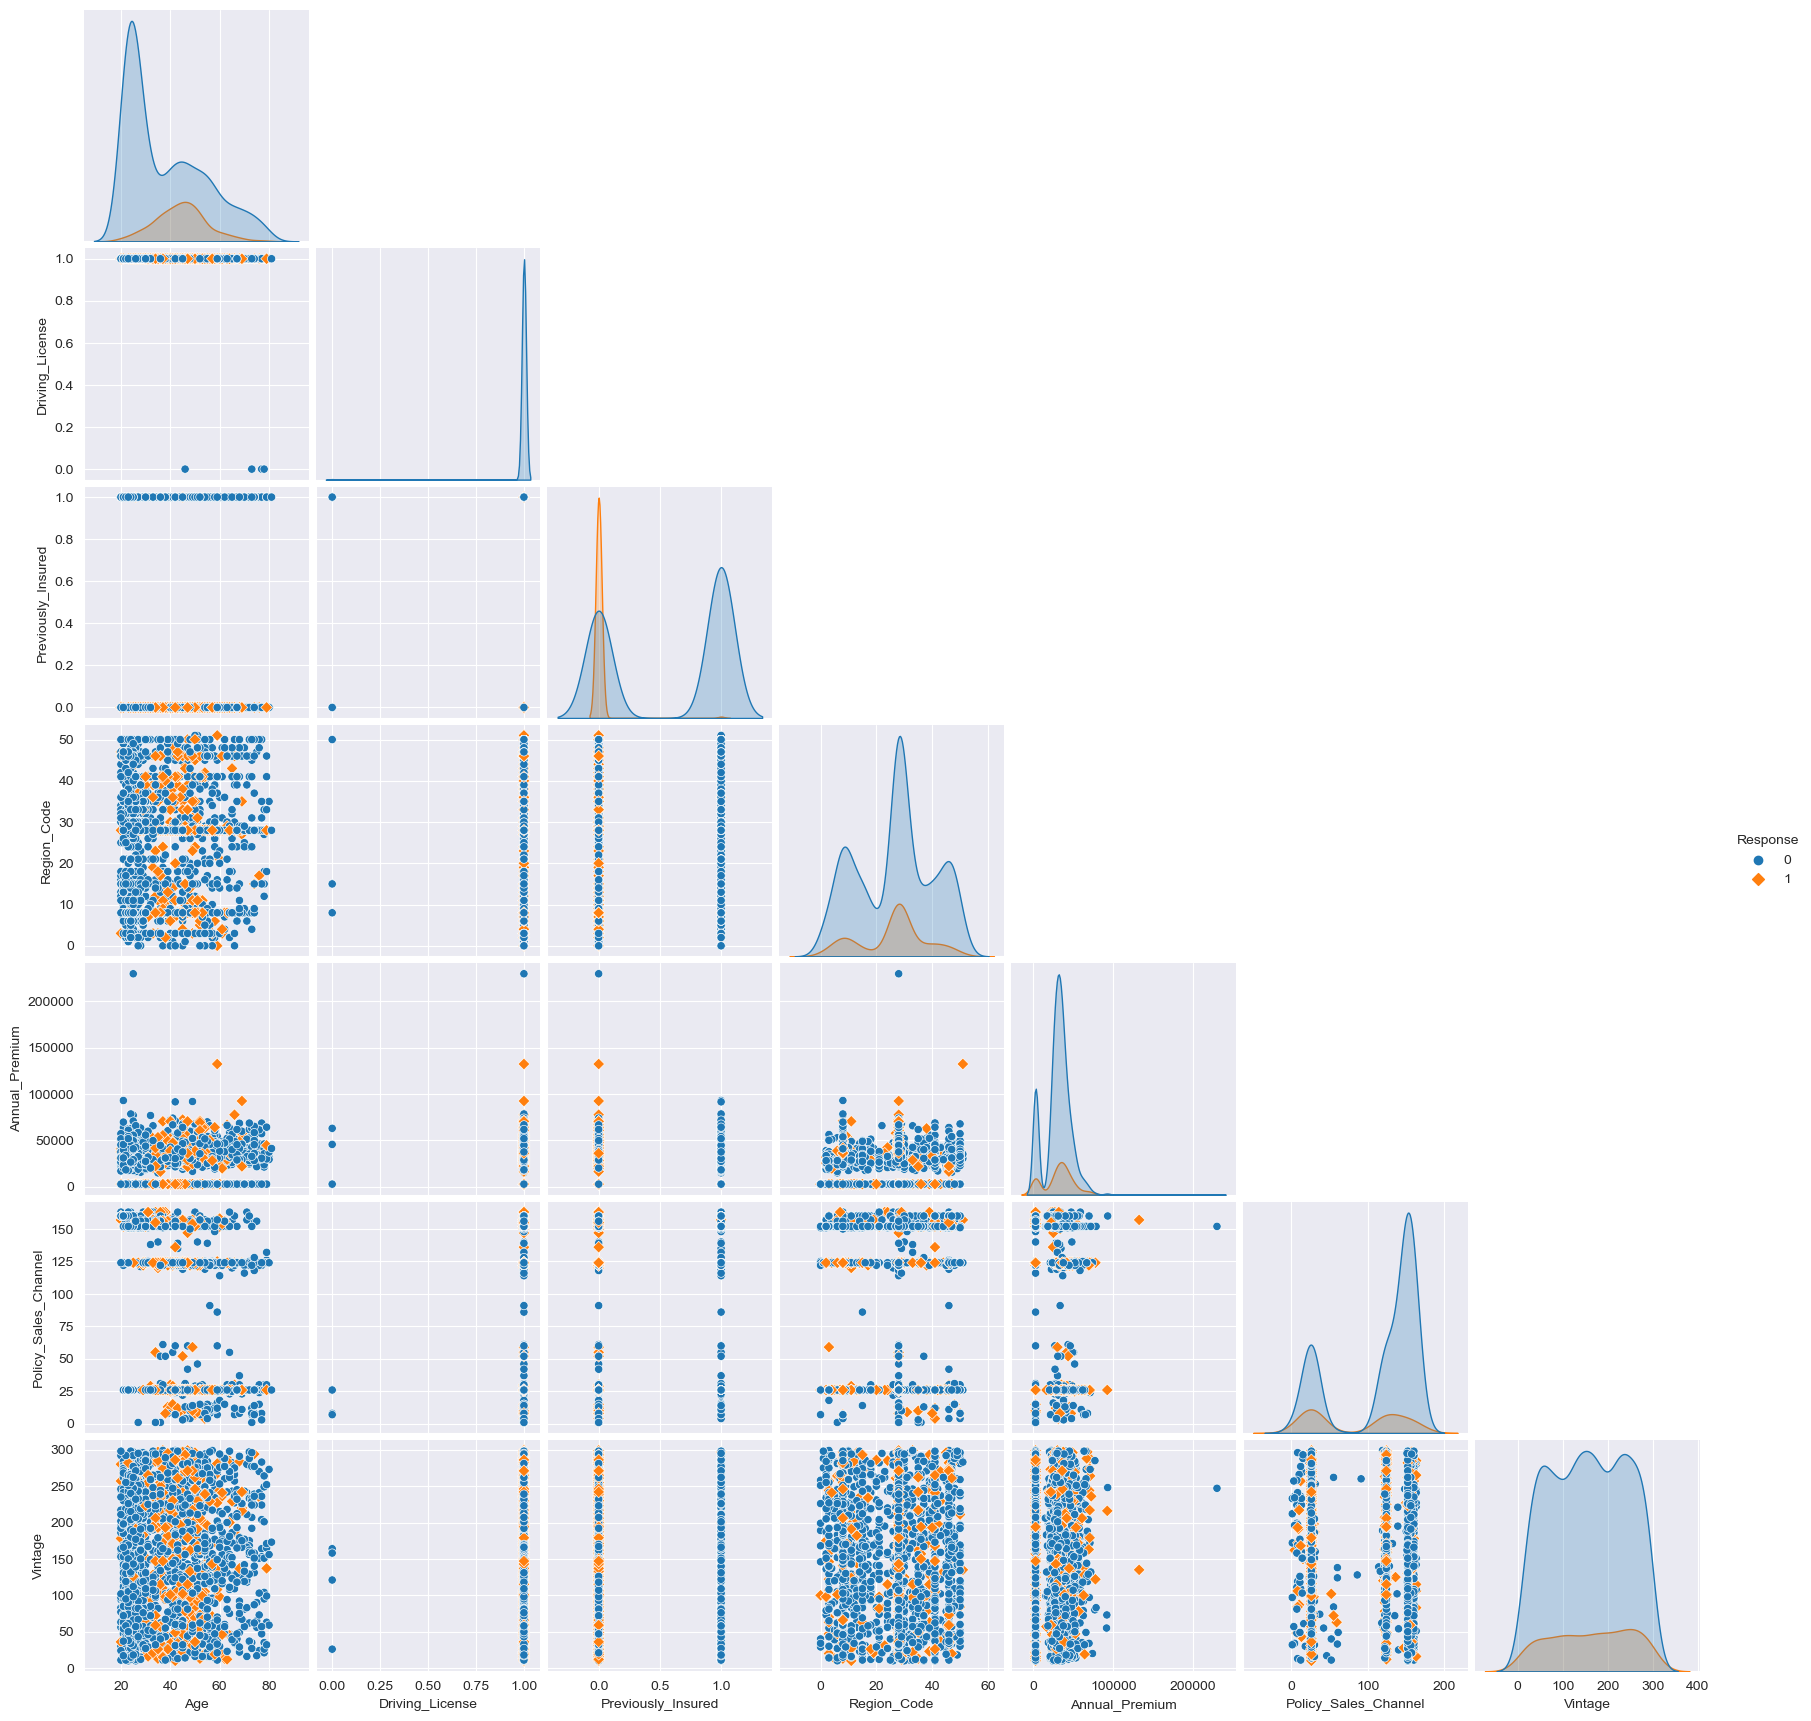

In [7]:
number_of_elements = 2000
sns.pairplot(dataframe_train.sample(n=2000)[dataframe_all + [result_column]],
             hue=result_column, corner=True, markers=["o", "D"])

Так как признак id не играет важной роли в предсказании, то можем удалить его из датафрейма.

In [8]:
dataframe_train.drop("id", axis=1, inplace=True)
dataframe_result.drop("id", axis=1, inplace=True)
test_ids = dataframe_test["id"]

In [9]:
for column in dataframe_categorical:
    print(dataframe_train[column].unique())

['Male' 'Female']
['< 1 Year' '1-2 Year' '> 2 Years']
['No' 'Yes']


In [10]:
dataframe_train[dataframe_numerical].describe()

,Age,Driving_License,Previously_Insured,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage
count,20000.000000,20000.000000,20000.000000,20000.0000,20000.000000,20000.00000,20000.000000
mean,38.633650,0.997700,0.491950,26.3114,30471.995200,111.89245,153.723650
std,15.298449,0.047904,0.499948,13.2026,17063.765281,54.33299,83.638826
min,20.000000,0.000000,0.000000,0.0000,2630.000000,1.00000,10.000000
25%,25.000000,1.000000,0.000000,15.0000,24237.500000,26.00000,81.000000
50%,36.000000,1.000000,0.000000,28.0000,31533.500000,147.00000,153.000000
75%,49.000000,1.000000,1.000000,35.0000,39256.500000,152.00000,226.000000
max,83.000000,1.000000,1.000000,52.0000,399010.000000,163.00000,299.000000


Произведём кодирование категориальных признаков

In [11]:
label_encoder = LabelEncoder()
for column in dataframe_categorical:
    dataframe_train[column] = label_encoder.fit_transform(
        dataframe_train[column])
    dataframe_result[column] = label_encoder.fit_transform(dataframe_result[column])
    dataframe_test[column] = label_encoder.fit_transform(dataframe_test[column])

    dataframe_train[column] = dataframe_train[column].astype("category")
    dataframe_result[column] = dataframe_result[column].astype("category")
    dataframe_test[column] = dataframe_test[column].astype("category")
    print(dataframe_train[column].unique())

[1, 0]
Categories (2, int64): [0, 1]
[1, 0, 2]
Categories (3, int64): [0, 1, 2]
[0, 1]
Categories (2, int64): [0, 1]


Произведём нормирование всех числовых признаков

In [12]:
min_max_scaler = MinMaxScaler()
dataframe_train[dataframe_numerical] = min_max_scaler.fit_transform(
    dataframe_train[dataframe_numerical])
dataframe_result[dataframe_numerical] = min_max_scaler.fit_transform(dataframe_result[dataframe_numerical])
dataframe_test[dataframe_numerical] = min_max_scaler.fit_transform(
    dataframe_test[dataframe_numerical])
dataframe_train.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.295772,0.997700,0.505988,0.491950,0.070241,0.684521,0.497314,0.163300
std,0.242833,0.047904,0.253896,0.499948,0.043049,0.335389,0.289408,0.369648
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.079365,1.000000,0.288462,0.000000,0.054512,0.154321,0.245675,0.000000
50%,0.253968,1.000000,0.538462,0.000000,0.072919,0.901235,0.494810,0.000000
75%,0.460317,1.000000,0.673077,1.000000,0.092402,0.932099,0.747405,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Отбор информативных признаков
Отбор информативных признаков - это процесс выбора наиболее значимых признаков из набора данных для использования в модели машинного обучения. Он помогает улучшить качество модели и сократить время её обучения. Если в наборе данных есть много признаков, которые не имеют большого влияния на результаты моделирования, то отбрасывание этих признаков улучшит качество модели. Существует несколько методов отбора информативных признаков, таких как обертывание, фильтрация и встроенные методы.

Этот код разделяет данные на обучающий и тестовый наборы с помощью функции train_test_split из библиотеки sklearn.model_selection. Функция train_test_split разделяет данные на обучающий и тестовый наборы в соотношении 70/30.

In [13]:
x = dataframe_train[dataframe_all]
y = dataframe_train[result_column]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                    random_state=7)
number_best_features = 5

### Метод фильтрации
Метод фильтрации - это метод отбора признаков на основе их статистических свойств. Он основан на оценке значимости каждого признака по отдельности и выборе наиболее значимых признаков. Примерами таких методов можно назвать корреляционный анализ и анализ дисперсии.
В этом коде используется метод SelectKBest из библиотеки scikit-learn для выбора лучших признаков из набора данных. Переменная skb создает объект SelectKBest с параметром k=number_best_features, указывающий количество наилучших признаков, которые будут выбраны. Метод fit() применяется к skb и используется для обучения модели на данных x и y. Метод get_feature_names_out() возвращает список лучших признаков.

In [14]:
skb = SelectKBest(score_func=chi2,
                  k=number_best_features)  # SelectKBest использует ANOVA F-значение для оценки важности каждого признака и выбирает лучшие признаки на основе этой оценки.
top_five = skb.fit(x,
                   y)  # Используется для обучения модели на данных x и целевой переменной y.
list_of_best_features = top_five.get_feature_names_out()
print(list_of_best_features)

['Age' 'Previously_Insured' 'Policy_Sales_Channel' 'Vehicle_Age'
 'Vehicle_Damage']


### Метод обёртки
Метод обертывания - это метод отбора признаков на основе обучения модели машинного обучения с использованием различных наборов признаков. Он основан на оценке качества модели для каждого набора признаков и выборе наилучшего набора.
В коде используется метод обертывания Recursive Feature Elimination из библиотеки scikit-learn для выбора лучших признаков из набора данных. Переменная clf создает объект LinearRegression(), который используется в качестве модели машинного обучения.

Переменная rfe создает объект RFE с параметрами clf, n_features_to_select=n_features_select и step=1. Параметр number_best_features указывает количество лучших признаков, которые будут выбраны. Параметр step указывает шаг уменьшения количества признаков на каждой итерации. Метод fit() применяется к объекту rfe и используется для обучения модели на данных x и y. Метод get_feature_names_out() возвращает список лучших признаков.

In [15]:
lr = LinearRegression()

rfe = RFE(lr, n_features_to_select=number_best_features)  # опираемся на значение производительности
top_five = rfe.fit(x, y)
selected_features_RFE = top_five.get_feature_names_out()
print(selected_features_RFE)

['Age' 'Previously_Insured' 'Annual_Premium' 'Policy_Sales_Channel'
 'Vehicle_Damage']


### Встроенные методы
Встроенные методы - это методы отбора признаков, которые включены в процесс обучения модели машинного обучения. Они основаны на оценке значимости каждого признака в процессе обучения модели и выборе наиболее значимых признаков.

In [16]:
selector = SelectFromModel(estimator=lr,
                           max_features=number_best_features)  # Мета-оценщик. Используется для извлечения лучших признаков из заданного набора данных в соответствии с важностью весов.
# Параметр estimator - оценщик, который используется для выбора признаков
top_five = selector.fit(x, y)
selected_features_built_in = top_five.get_feature_names_out()
print(selected_features_built_in)

['Age' 'Previously_Insured' 'Annual_Premium' 'Vehicle_Damage']


### Сравнение полученных результатов
Используем метод Gaussian Naive Bayes из библиотеки Scikit-learn для обучения модели машинного обучения на данных x_train и y_train. Он реализует гауссовский наивный байесовский алгоритм для классификации. Переменная model создает объект GaussianNB() и применяет к нему метод fit() с параметрами x_train и y_train, это обучает модель на данных. Переменная masks хранит список масок, каждая из которых содержит True для каждого признака в x_train. Переменная scoring хранит список оценок ROC-AUC для каждой маски. Метод predict_proba() применяется к модели и используется для предсказания вероятности классов на данных x_test. Метод roc_auc_score() вычисляет оценку ROC-AUC для предсказанных вероятностей и фактических значений y_test.

Рассчитаем значение оценки для изначального фрейма данных.

In [17]:
masks = scoring = tuple()
model = GaussianNB().fit(x_train, y_train)
masks += ([True for _ in range(x_train.shape[1])],)
scoring = (roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]),)
print("ROC-AUC: " + str(round(scoring[-1], 3)))

ROC-AUC: 0.862


Создаём словарь values_dict, который содержит три метода отбора признаков: chi2, rfe и built-in, проходим по каждому методу отбора признаков и выполняем подсчет оценки. Создаём объект GaussianNB() и применяем к нему метод fit() с параметрами selector.transform(x_train) и y_train. Это обучит модель на данных, отобранных методом selector.

In [18]:
lists_of_features = [list_of_best_features, selected_features_RFE,
                     selected_features_built_in]
scoring = tuple()

values_dict = {
    "chi2": skb,
    "rfe": rfe,
    "built-in": selector,
}

for selector_name, selector in values_dict.items():
    model = GaussianNB().fit(selector.transform(x_train), y_train)
    masks += (selector.get_support(),)
    scoring += (roc_auc_score(y_test,
                              model.predict_proba(selector.transform(x_test))[:,
                              1]),)
    print("ROC-AUC: " + str(round(scoring[-1], 3)))  # название модели добавить

ROC-AUC: 0.86
ROC-AUC: 0.862
ROC-AUC: 0.867


Исходя из результатов выбираем лучшую модель.

In [19]:
best_selected_features = lists_of_features[scoring.index(max(scoring))]

## Удаление незначимых признаков

In [20]:
dataframe_train = dataframe_train.loc[:, np.append(best_selected_features,
                                                   result_column)]  # loc используется для выборки строк и столбцов
dataframe_test = dataframe_test.loc[:, best_selected_features]
dataframe_result = dataframe_result.loc[:, np.append(best_selected_features, result_column)]

dataframe_all = best_selected_features

x = dataframe_train[dataframe_all]
y = dataframe_train[result_column]

In [21]:
dataframe_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 100668 to 97582
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 20000 non-null  float64 
 1   Previously_Insured  20000 non-null  float64 
 2   Annual_Premium      20000 non-null  float64 
 3   Vehicle_Damage      20000 non-null  category
 4   Response            20000 non-null  int64   
dtypes: category(1), float64(3), int64(1)
memory usage: 800.9 KB


## Сэмплирование данных
Семплирование данных - это метод корректировки обучающей выборки с целью балансировки распределения классов в исходном наборе данных.

In [22]:
# RandomUnderSampler, ClusterCentroids, InstanceHardnessThreshold, NearMiss, TomekLinks, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, OneSidedSelection, CondensedNearestNeighbour, NeighbourhoodCleaningRule

samplers = {
    "default": (x, y),

    "RandomOverSampler": RandomOverSampler().fit_resample(x, y),
    "ADASYN": ADASYN().fit_resample(x, y),
    "KMeansSMOTE": KMeansSMOTE(cluster_balance_threshold=0.3).fit_resample(x, y),
    "SMOTE": SMOTE(k_neighbors=2).fit_resample(x, y),
    "BorderlineSMOTE": BorderlineSMOTE().fit_resample(x, y),
    "SVMSMOTE": SVMSMOTE().fit_resample(x, y),
    "SMOTEN": SMOTEN().fit_resample(x, y),

    "RandomUnderSampler": RandomUnderSampler().fit_resample(x, y),
    "InstanceHardnessThreshold": InstanceHardnessThreshold().fit_resample(x, y),
    "NearMiss": NearMiss().fit_resample(x, y),  # Самое большое значение
    "TomekLinks": TomekLinks().fit_resample(x, y),
    "EditedNearestNeighbours": EditedNearestNeighbours().fit_resample(x, y),
    "RepeatedEditedNearestNeighbours": TomekLinks().fit_resample(x, y),
    "RepeatedEditedNearestNeighbours": RepeatedEditedNearestNeighbours().fit_resample(x, y),

    "AllKNN": AllKNN().fit_resample(x, y),      # собрать вывод в строчку или столбец либо датафрейм
    #"OneSidedSelection": OneSidedSelection().fit_resample(x, y),
    #"CondensedNearestNeighbour": CondensedNearestNeighbour().fit_resample(x, y),
    #"NeighbourhoodCleaningRule": NeighbourhoodCleaningRule().fit_resample(x, y),
}
# вывести количество элементов первого и второго класса для каждых элементов рядом с каждым скором
scoring = tuple()

print("ROC-AUC:")

for sampler, values in samplers.items():
    scoring += (round(max(cross_val_score(GaussianNB(), values[0], values[1], scoring="roc_auc", n_jobs=-1)), 3),)
    print(scoring[-1])

ROC-AUC:
0.871
0.877
0.86
0.935
0.875
0.874
0.893
0.925
0.883
0.996
0.594
0.898
0.962
0.973
0.966


Возьмём самое лучшее значение.

In [23]:
max_index = scoring.index(max(scoring[1:]))
x, y = list(samplers.values())[max_index]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                    random_state=7)  # random_state устанавливает начальное значение для генератора случайных чисел.

## Построение моделей классификаторов
Построение моделей классификаторов - это процесс создания алгоритма машинного обучения, который может классифицировать данные на основе определенных признаков. Есть множество методов и алгоритмов для построения моделей классификаторов в зависимости от типа данных и задачи классификации:
1. Логистическая регрессия
2. Метод ближайших соседей
3. Наивный байесовский классификатор
4. Дискриминантный анализ (линейный дискриминантный анализ,
квадратичный дискриминантный анализ)
5. Машина опорных векторов.

Напишем функцию для создания и обучения модели. algorythm - алгоритм, с помощью которого мы будем обучать нашу модель. param_grid - это словарь, который содержит набор параметров для модели машинного обучения. Каждый ключ в словаре соответствует имени параметра, а значение - списку возможных значений параметра. GridSearchCV будет перебирать все возможные комбинации значений параметров из словаря param_grid и выбирать ту комбинацию, которая дает наилучший результат на кросс-валидации. Обучаем модель на данных x_train, y_train и оцениваем на тестовых данных x_test и y_test с помощью метрики ROC-AUC.

In [24]:
def create_train_model(algorythm, param_grid=None) -> GridSearchCV:
    """
    Создаёт и обучает модель
    :param algorythm: используемый алгоритм
    :param param_grid: параметры сетки
    :return: модель
    """
    if param_grid is None:
        param_grid = {}
    print("Создание и обучение модели...")
    """Создать и обучить модель с подбором параметров."""
    new_model = GridSearchCV(algorythm, param_grid, n_jobs=-1,
                             scoring="roc_auc").fit(x_train, y_train)
    if param_grid:
        print(new_model.best_estimator_)
    print("ROC-AUC: " + str(round(new_model.score(x_test, y_test), 3)))
    return new_model

### Логистическая регрессия
Логистическая регрессия - статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой.

In [25]:
param_grid = {
    "penalty": ["l1", "l2"],
    "solver": ["saga", "liblinear"],
    "max_iter": range(1, 10),
    "C": [0.1, 1, 10]
    # Регуляризация модели. Определяет, насколько сильно мы хотим штрафовать за ошибки в модели.
}

lg = create_train_model(LogisticRegression(), param_grid)

Создание и обучение модели...
LogisticRegression(C=1, max_iter=1, penalty='l1', solver='saga')
ROC-AUC: 0.982


### Метод ближайших соседей

In [26]:
# "metric" - это параметр, который определяет метрику расстояния между точками.
# "euclidean" - это евклидово расстояние между точками. Оно вычисляется как корень из суммы квадратов разностей координат точек.
# "manhattan" - это расстояние городских кварталов между точками. Оно вычисляется как сумма абсолютных разностей координат точек.

param_grid = {
    "n_neighbors": range(10, 30),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]  #
}

knc = create_train_model(KNeighborsClassifier(), param_grid)

Создание и обучение модели...
KNeighborsClassifier(metric='manhattan', n_neighbors=28)
ROC-AUC: 0.997


### Наивный байесовский классификатор
Наивный байесовский классификатор - это алгоритм классификации, основанный на теореме Байеса.

In [27]:
params = dict()
gnb = create_train_model(GaussianNB(), params)

Создание и обучение модели...
ROC-AUC: 0.995


### Линейный дискриминантный анализ

In [28]:
params = {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.5, 0.9]}
lda = create_train_model(LinearDiscriminantAnalysis(), params)

Создание и обучение модели...
LinearDiscriminantAnalysis(shrinkage=0.9, solver='lsqr')
ROC-AUC: 0.982


### Квадратичный дискриминантный анализ

In [29]:
params = {'store_covariance': [True, False],
          'reg_param': [0, 0.1, 0.25, 0.5, 0.7, 1]}
qda = create_train_model(QuadraticDiscriminantAnalysis(), params)

Создание и обучение модели...
QuadraticDiscriminantAnalysis(reg_param=0, store_covariance=True)
ROC-AUC: 0.996


### Машина опорных векторов

In [30]:
svc = create_train_model(SVC(probability=True))

Создание и обучение модели...
ROC-AUC: 0.996


## Построение ROC кривых и столбчатой диаграммы score

In [31]:
models = (lg, knc, gnb, lda, qda, svc)
names = scoring = probs = tuple()
for model in models:
    names += (model.best_estimator_.__class__.__name__,)
    scoring += (round(model.score(x_test, y_test), 3),)
    probs += (model.predict_proba(x_test)[:, 1],)

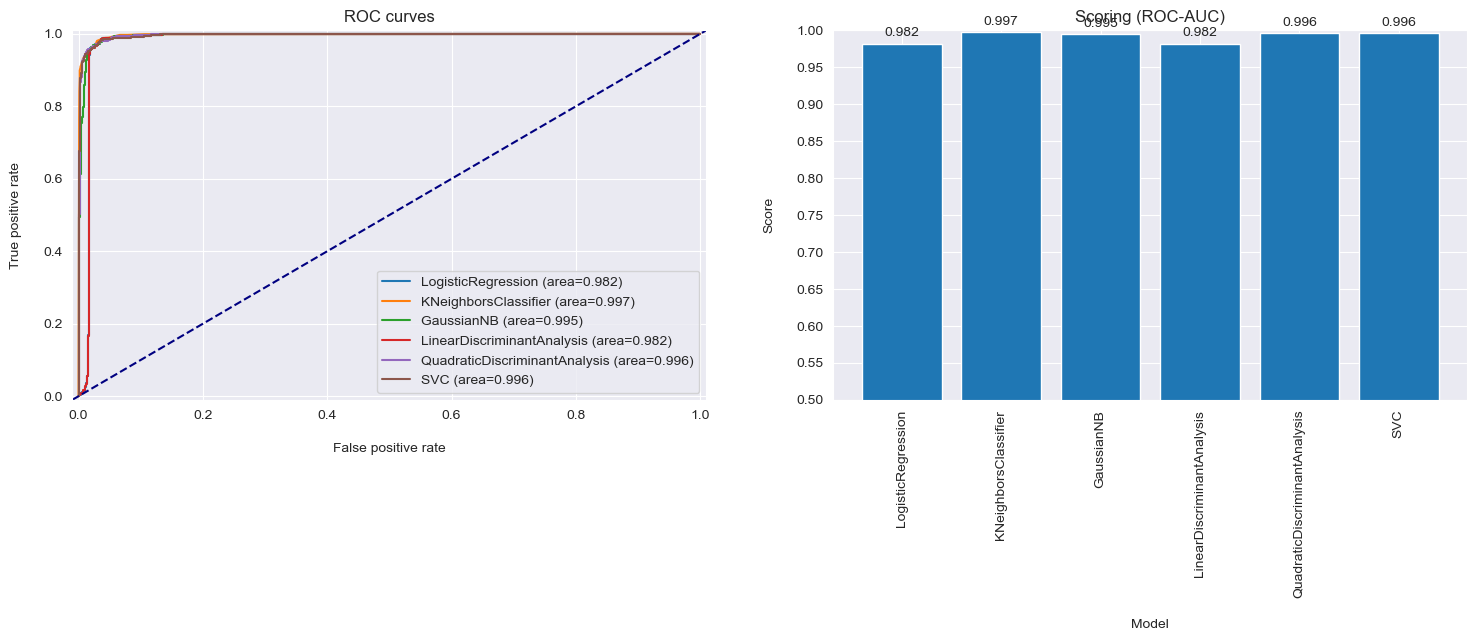

In [32]:
fig, axes = plt.subplots(1, 2)  # берем макс прибавляем значение
fig.set_figwidth(18)
plot_roc_curves(axes[0], probs, names, y_test, axes)
plot_bar_graph(axes[1], names, scoring)
plt.show()

In [33]:
best_model = models[scoring.index(max(scoring))]
print("В результате анализа была выбрана модель: " + str(
    best_model.best_estimator_))

В результате анализа была выбрана модель: KNeighborsClassifier(metric='manhattan', n_neighbors=28)


Прогоним нашу модель на dataframe_result.

In [35]:
x = dataframe_result[dataframe_all]
y = dataframe_result[result_column]
_, x_test_res, _, y_test_res = train_test_split(x, y, test_size=0.3,
                                                    random_state=7)
print("dataframe_result ROC-AUC: " + str(round(best_model.score(x_test_res, y_test_res), 3)))

dataframe_result ROC-AUC: 0.866


Записываем предсказания наилучшей модели в файл

In [36]:
with open("../data/submission.csv", "w", encoding="utf-8") as csv:
    writer = DictWriter(
        csv, delimiter=",", lineterminator="\r",
        fieldnames=["PassengerId", "Survived"]
    )
    writer.writeheader()

    dataframe_test = dataframe_test.loc[:, best_selected_features]
    prediction = best_model.predict(dataframe_test)

    for i, predict in enumerate(prediction):
        writer.writerow({"PassengerId": test_ids[i], "Survived": predict})